In [146]:
import numpy as np
import pandas as pd
import json
from scipy import stats

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import bike_project as bp

In [147]:
urls = {
        'Fremont' : 'https://data.seattle.gov/resource/65db-xm6k.json',
        'Ballard' : 'https://data.seattle.gov/resource/47yq-6ugv.json',
        'Capitol_Hill' : 'https://data.seattle.gov/resource/j4vh-b42a.json',
        'Central_2nd_Ave' : 'https://data.seattle.gov/resource/avwm-i8ym.json',
# no data until 2019        'Central_7th_Ave' : 'https://data.seattle.gov/resource/qfzg-zmyj.json', 
        'West_Seattle' : 'https://data.seattle.gov/resource/mefu-7eau.json',
        'I90_lid' : 'https://data.seattle.gov/resource/u38e-ybnc.json',
        'NE_Seattle' : 'https://data.seattle.gov/resource/2z5v-ecg8.json',
        'Myrtle_Edwards' : 'https://data.seattle.gov/resource/4qej-qvrz.json',
        'Spokane_Street' : 'https://data.seattle.gov/resource/upms-nr8w.json'
        }

bike_shops = {
        'Fremont' : 8,
        'Ballard' : 3,
        'Capitol_Hill' : 2,
        'Central_2nd_Ave' : 5,
#         'Central_7th_Ave' : 6,
        'West_Seattle' : 3,
        'I90_lid' : 5,
        'NE_Seattle' :6 ,
        'Myrtle_Edwards' : 3,
        'Spokane_Street' : 2
}


## Functions written for Seattle Spins: bike trip counter analysis

In [198]:
def r_w_bike_trips(path, location_name, num_shops, app_token, limit=50000, offset=50000):
    '''
    Reads an API accessible dataset given url path and other url call variables.
    Writes out to a json file

    Parameters:
    -----------
    path (str): url path beginning with https:
    location_name (str): name to assign to the trip counts column
    token (str): app_token
    limit (int): max rows to request
    offset (int): starting point for gathering rows

    Output:
    --------
    json-formatted file named 'location_name.json'
    '''
    df_a = pd.read_json( f'{path}?$limit={limit}&$offset={0}&$$app_token={app_token}')
    df_b = pd.read_json( f'{path}?$limit={limit}&$offset={offset}&$$app_token={app_token}')
    df = df_a.append(df_b)    
    # rename trip_count column to location_name
    df[location_name] = df.iloc[:, -2:].sum(axis=1)
    
    # calculate date, month, year, dow, commuter (boolean), trip count am peak, trip count other times
    df['short_date'] = pd.DatetimeIndex(df['date']).date
    df['month'] = pd.DatetimeIndex(df['date']).month
    df['year'] = pd.DatetimeIndex(df['date']).year
    df['dow'] = pd.DatetimeIndex(df['date']).dayofweek
    df['hour'] = pd.DatetimeIndex(df['date']).hour
    df['am_commuter'] = df['dow'].isin([0,1,2,3,4]) & (df['hour'].isin([5,6,7,8,9]))
    df[f'{location_name}_am_peak'] = np.where(df['am_commuter']==True, df[location_name], 0)
    df[f'{location_name}_other'] = np.where(df['am_commuter']==False, df[location_name], 0)
    
    # collapse table by date and create sum counts for commuter and (other-(2 x commuter))
    df = df.groupby(['short_date', 'month', 'year', 'dow']).agg(
                                        {f'{location_name}_am_peak':'sum',
                                         f'{location_name}_other':'sum'
                                          }).reset_index()
    
    # remove years prior to 2015
    df = df[df['year'] >= 2015]
    
    # commuters travel 2 ways--remove assumed pm commuter trips from trip count other
    df[f'{location_name}_other'] = df[f'{location_name}_other'] - df[f'{location_name}_am_peak']

    # add in count of nearby bike shops
    df[f'{location_name}_bike_shops'] = num_shops
    df.to_json(f'data/{location_name}.json', date_format='iso')
    
    #test output to be sure the read operation went ok
    print(df.head())
    

In [199]:
def merge_counter_locations(location_dict):
    '''
    Loops through a dict of counter locations, creating a json file path for each 
    location and merging counter files by date to create a master bike trip
    count file with 'am_peak' and 'other' bike trips for each location for each day.

    Parameters:
    ----------
    location_dict (dict): dict with root names of json files

    Returns:
    -------
    df (dataframe): master bike trip count file
    '''
    count = 1
    for k,v in urls.items():
        if count == 1:
            df = pd.read_json(f'data/{k}.json')
        else:
            df_next = pd.read_json(f'data/{k}.json')
            df = df.merge(df_next, how="left", left_on=["short_date", "month", "year", "dow"], right_on=['short_date', "month", "year", "dow"])
        count += 1
    df['date'] = pd.DatetimeIndex(df['short_date']).date
    return df


In [200]:
def add_weather(df, weather_file, keep_cols):
    '''
    Reads in daily weather data from a NOAA-generated source and merges it
    into a dataframe by date
    Parameters:
    ----------
    df (dataframe): destination dataframe
    weather_file (.csv): source weather .csv file
    keep_cols (list): list of weather attributes to keep

    Returns:
    -------
    Updated dataframe
    '''
    df_seattle_weather = pd.read_csv(weather_csv, usecols=keep_cols)
    df_seattle_weather['date'] = pd.DatetimeIndex(df_seattle_weather["DATE"]).date
    df = df.merge(df_seattle_weather, how="left", left_on="date", right_on='date')
    df.index = df['date']
    return df

In [201]:
def add_daily_summary_data(df, bike_shops_d):
    '''
    Adds daily summary statistics for trip counts
    Parameters:
    ----------
    df (dataframe): pandas table of bike counts by station
    bike_shops_d (dict): dict with number of bike shops in vicinity of bike trip counter location
    
    Returns:
    -------
    df (dataframe): df with summary statistics added
    '''
    few_am_peak, many_am_peak, few_other, many_other = [], [], [], []

    for k,v in bike_shops.items():
        if v <= 3:
            few_am_peak.append('{}_am_peak'.format(k))
            few_other.append(f'{k}_other')
        else:
            many_am_peak.append(f'{k}_am_peak')
            many_other.append(f'{k}_other')

    df['few_am_peak_ttl'] = df[few_am_peak].sum(axis=1)
    df['many_am_peak_ttl'] = df[many_am_peak].sum(axis=1)
    df['few_other_ttl'] = df[few_other].sum(axis=1)
    df['many_other_ttl'] = df[many_other].sum(axis=1)
    df['am_peak_ttl'] = df['few_am_peak_ttl'] + df['many_am_peak_ttl']
    df['other_ttl'] = df['few_other_ttl'] + df['many_other_ttl']
    return df
    

## Function calls follow.

#### This function call to 'r_w_bike_trips' reads externally-sourced raw data and writes one json output file per location. 

In [202]:
# No need to rerun this cell--it reads data from external sources and creates locally-stored json files. 

limit = 30000
offset = 30000

with open('data/app_token.txt', 'r') as t_file: 
    app_token = t_file.read() 

for k, v in urls.items():
    r_w_bike_trips(v, k, bike_shops[k], app_token, limit, offset)

     short_date  month  year  dow  Fremont_am_peak  Fremont_other  \
820  2015-01-01      1  2015    3             48.0          615.0   
821  2015-01-02      1  2015    4            404.0          406.0   
822  2015-01-03      1  2015    5              0.0          817.0   
823  2015-01-04      1  2015    6              0.0          339.0   
824  2015-01-05      1  2015    0            693.0          437.0   

     Fremont_bike_shops  
820                   8  
821                   8  
822                   8  
823                   8  
824                   8  
     short_date  month  year  dow  Ballard_am_peak  Ballard_other  \
365  2015-01-01      1  2015    3              0.0           84.0   
366  2015-01-02      1  2015    4             17.0          362.0   
367  2015-01-03      1  2015    5              0.0          375.0   
368  2015-01-04      1  2015    6              0.0          303.0   
369  2015-01-05      1  2015    0             76.0          284.0   

     Ballard_b

#### This function call brings all locations together into one master dataframe.

In [255]:
df = merge_counter_locations(urls)


#### This function call appends daily weather data.


In [256]:
weather_csv = 'data/weather.csv'
use_cols = ['DATE',"PRCP","TAVG","TMAX","TMIN"]
df = add_weather(df, weather_csv, use_cols)

#### This function call adds daily summary statistics for bike trip counts.

In [257]:
df = add_daily_summary_data(df, bike_shops)

## EDA

- Various views of the data were undertaken to get a sense of how bike trips for commuters and other riders differ according to number of bike shops close by where they were counted and by day of week, month, year, and weather.
- The first view was to look at average daily trip counts by location and by 'am peak' and 'other'. Note that 'other' is a proxy for non-commuter trips. It equals total trip counts minus 2x 'am peak' trip counts.

In [258]:
df.filter(regex=(".*am_peak.*")).mean()

Fremont_am_peak             845.607738
Ballard_am_peak              17.581114
Capitol_Hill_am_peak         60.668106
Central_2nd_Ave_am_peak     218.016071
West_Seattle_am_peak         26.857748
I90_lid_am_peak             109.530357
NE_Seattle_am_peak          170.573214
Myrtle_Edwards_am_peak      294.173214
Spokane_Street_am_peak      261.716667
few_am_peak_ttl             658.125595
many_am_peak_ttl           1343.727381
am_peak_ttl                2001.852976
dtype: float64

In [259]:
df.filter(regex=(".*other.*")).mean()

Fremont_other            1106.281548
Ballard_other              90.449153
Capitol_Hill_other        173.135102
Central_2nd_Ave_other     354.286905
West_Seattle_other         36.285109
I90_lid_other             357.657738
NE_Seattle_other          653.385119
Myrtle_Edwards_other      557.508929
Spokane_Street_other      290.859524
few_other_ttl            1140.045238
many_other_ttl           2471.611310
other_ttl                3611.656548
dtype: float64

## STATS QUESTIONS 

> **What do the distributions of daily trip counts look like?**

> **What are boxplot statistics for these trips? What is 95% C.I. for AM peak daily counts?**

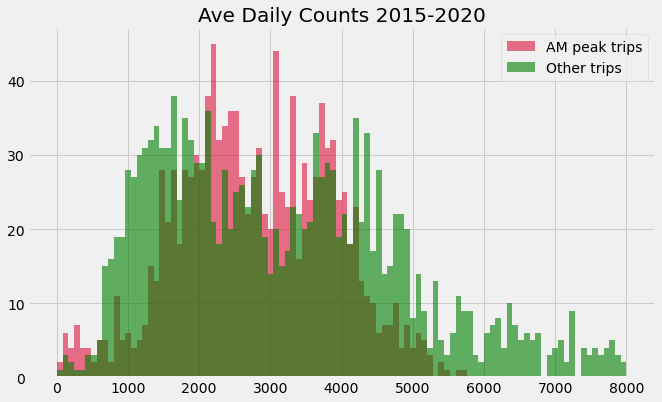

In [260]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(df['am_peak_ttl'], range=(1,8000), bins=100, color='crimson', label='AM peak trips', alpha=0.6);
ax.hist(df['other_ttl'], range=(1,8000), bins=100, color='green', label ='Other trips', alpha=0.6);
ax.set_title("Ave Daily Counts 2015-2020")

ax.legend();


Text(0.5, 1.0, 'other ttl')

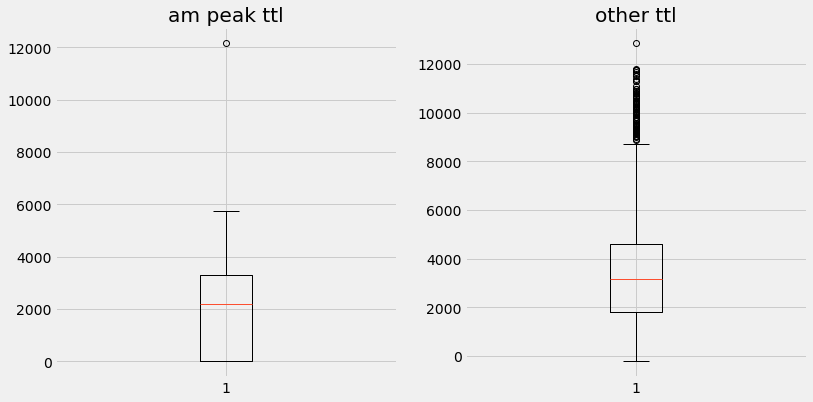

In [261]:
fig, axs = plt.subplots(1,2, figsize=(12, 6))
axs[0].boxplot(df['am_peak_ttl']);
axs[1].boxplot(df['other_ttl']);
# ax.hist(df['other_ttl'], range=(1,8000), bins=100, color='green', label ='Other trips', alpha=0.6);
axs[0].set_title("am peak ttl")
axs[1].set_title("other ttl")

# ax.legend();


In [247]:
by_dow = df[['am_peak_ttl', 'other_ttl', 'few_am_peak_ttl', 'many_am_peak_ttl', 'few_other_ttl', 'many_other_ttl', 'year', 'month', 'dow']].groupby('dow').mean().reset_index()
by_dow['am_peak_ttl'].replace(0, np.NaN, inplace=True)
by_dow

,dow,am_peak_ttl,other_ttl,few_am_peak_ttl,many_am_peak_ttl,few_other_ttl,many_other_ttl,year,month
0,0,2748.754167,2899.495833,907.275000,1841.479167,929.387500,1970.108333,2016.829167,6.204167
1,1,3041.533333,2845.258333,1008.450000,2033.083333,902.520833,1942.737500,2016.833333,6.183333
2,2,3014.733333,2927.204167,991.579167,2023.154167,913.633333,2013.570833,2016.833333,6.216667
3,3,2758.795833,2903.229167,911.479167,1847.316667,916.841667,1986.387500,2016.816667,6.220833
4,4,2449.154167,2773.220833,788.095833,1661.058333,890.037500,1883.183333,2016.820833,6.208333
5,5,NaN,5555.550000,0.000000,0.000000,1724.195833,3831.354167,2016.820833,6.237500
6,6,NaN,5377.637500,0.000000,0.000000,1703.700000,3673.937500,2016.825000,6.220833


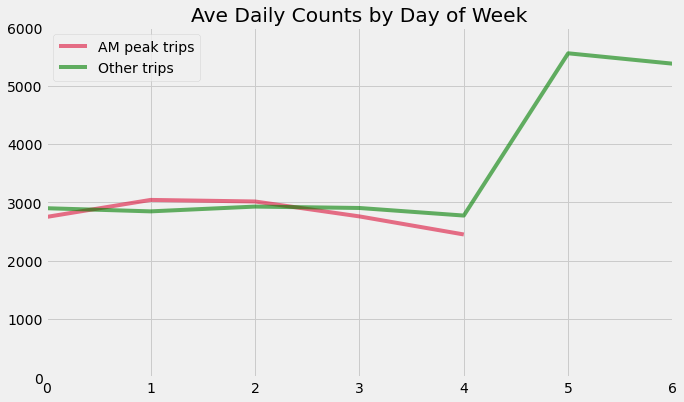

In [248]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(by_dow['dow'], by_dow['am_peak_ttl'], color = 'crimson', label='AM peak trips', alpha=0.6);
ax.plot(by_dow['dow'], by_dow['other_ttl'], color = 'green', label ='Other trips', alpha=0.6);
ax.set_xlim(0,6)
ax.set_ylim(0,6000)
ax.set_title("Ave Daily Counts by Day of Week")

ax.legend();


### The NE Seattle data donut
> 5/2018 is abnormally high and 6/2018 - 8/2018 are missing.

In [249]:

NE_Seattle = df[['NE_Seattle_am_peak', 'month', 'year']].groupby(['year', 'month']).sum().reset_index()

NE_Seattle[NE_Seattle['year'] == 2018]

,year,month,NE_Seattle_am_peak
36,2018,1,3192
37,2018,2,2603
38,2018,3,3899
39,2018,4,4972
40,2018,5,16067
41,2018,6,0
42,2018,7,0
43,2018,8,0
44,2018,9,4328
45,2018,10,5289


In [250]:
by_dow_year = df[['am_peak_ttl', 'other_ttl', 'few_am_peak_ttl', 'many_am_peak_ttl', 'few_other_ttl', 'many_other_ttl', 'year', 'month', 'dow']].groupby(['dow', 'year']).mean().reset_index()
by_dow_year['am_peak_ttl'].replace(0, np.NaN, inplace=True)
by_dow_year.head()


,dow,year,am_peak_ttl,other_ttl,few_am_peak_ttl,many_am_peak_ttl,few_other_ttl,many_other_ttl,month
0,0,2015,2618.076923,2989.500000,896.038462,1722.038462,974.576923,2014.923077,6.538462
1,0,2016,2659.423077,2835.480769,908.711538,1750.711538,931.096154,1904.384615,6.480769
2,0,2017,2647.692308,2619.942308,871.019231,1776.673077,817.596154,1802.346154,6.442308
3,0,2018,2735.415094,2787.471698,906.943396,1828.471698,971.000000,1816.471698,6.528302
4,0,2019,3310.129032,3516.354839,985.096774,2325.032258,967.096774,2549.258065,4.225806


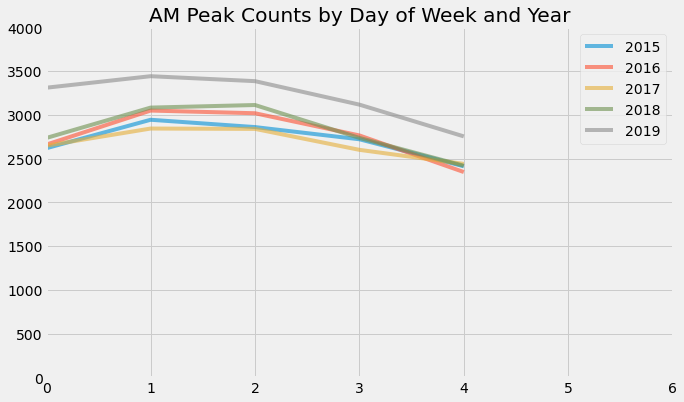

In [251]:
df['am_peak_ttl'].replace(0, np.NaN, inplace=True)
fig, ax = plt.subplots(figsize=(10, 6))
for yr in range(2015, 2020):
    ax.plot(by_dow['dow'], by_dow_year[by_dow_year['year'] == yr]['am_peak_ttl'], label=f'{yr}', alpha=0.6);
    
ax.set_xlim(0,6)
ax.set_ylim(0,4000)
ax.set_title("AM Peak Counts by Day of Week and Year")
ax.legend();
    
    

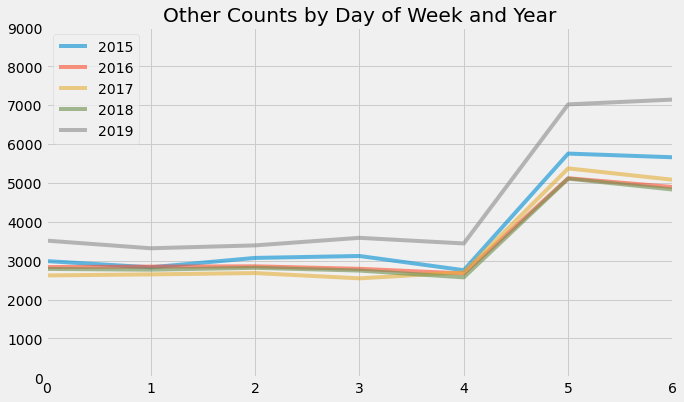

In [252]:
fig, ax = plt.subplots(figsize=(10, 6))
for yr in range(2015, 2020):
    ax.plot(by_dow['dow'], by_dow_year[by_dow_year['year'] == yr]['other_ttl'], label=f'{yr}', alpha=0.6);
    
ax.set_xlim(0,6)
ax.set_ylim(0,9000)
ax.set_title("Other Counts by Day of Week and Year")
ax.legend();
    
    

## STATS QUESTION 

> **Is Friday statistically the lowest riding day of the week?**

In [215]:
by_month = df[['am_peak_ttl', 'other_ttl', 'few_am_peak_ttl', 'many_am_peak_ttl', 'few_other_ttl', 'many_other_ttl',  'month']].groupby('month').mean().reset_index()
by_month.head()

,month,am_peak_ttl,other_ttl,few_am_peak_ttl,many_am_peak_ttl,few_other_ttl,many_other_ttl
0,1,1439.858065,2153.058065,503.109677,936.748387,765.729032,1387.329032
1,2,1250.425532,2033.163121,425.219858,825.205674,652.198582,1380.964539
2,3,1578.870968,3002.367742,495.296774,1083.574194,844.032258,2158.335484
3,4,1962.900000,3774.500000,652.866667,1310.033333,1164.200000,2610.300000
4,5,2935.748387,5251.387097,928.877419,2006.870968,1585.419355,3665.967742


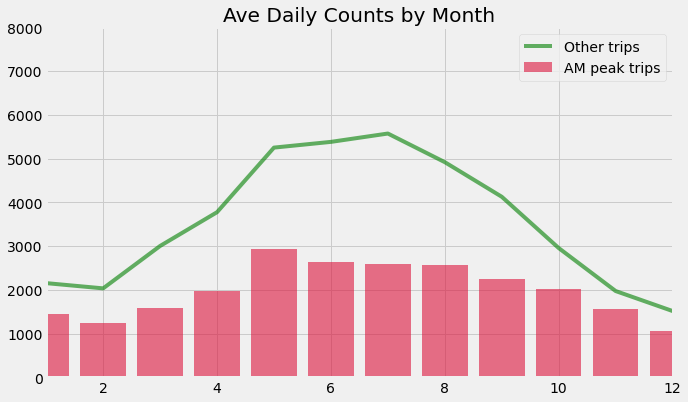

In [216]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(by_month['month'], by_month['am_peak_ttl'], color = 'crimson', label='AM peak trips', alpha=0.6);
ax.plot(by_month['month'], by_month['other_ttl'], color = 'green', label='Other trips', alpha=0.6);
ax.set_xlim(1,12)
ax.set_ylim(0,8000)

ax.set_title("Ave Daily Counts by Month")
ax.legend()

In [217]:
by_year = df[['am_peak_ttl', 'other_ttl', 'few_am_peak_ttl', 'many_am_peak_ttl', 'few_other_ttl', 'many_other_ttl',  'year']].groupby('year').mean().reset_index()
by_year.head()

,year,am_peak_ttl,other_ttl,few_am_peak_ttl,many_am_peak_ttl,few_other_ttl,many_other_ttl
0,2015,1938.660274,3737.726027,656.591781,1282.068493,1192.717808,2545.008219
1,2016,1972.519126,3432.956284,669.592896,1302.926230,1105.049180,2327.907104
2,2017,1904.854795,3382.852055,625.112329,1279.742466,1060.372603,2322.479452
3,2018,2014.254795,3373.668493,663.339726,1350.915068,1153.446575,2220.221918
4,2019,2297.191781,4478.178082,687.849315,1609.342466,1221.196347,3256.981735


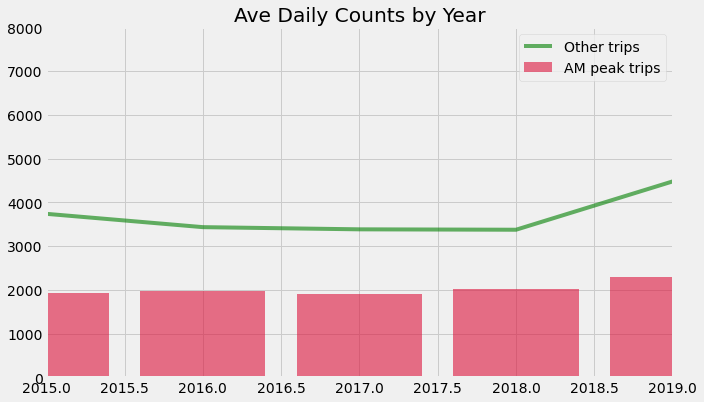

In [218]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(by_year['year'], by_year['am_peak_ttl'], color = 'crimson', label='AM peak trips', alpha=0.6);
ax.plot(by_year['year'], by_year['other_ttl'], color = 'green', label='Other trips', alpha=0.6);
ax.set_xlim(2015, 2019)
ax.set_ylim(0,8000)

ax.set_title("Ave Daily Counts by Year")
ax.legend()

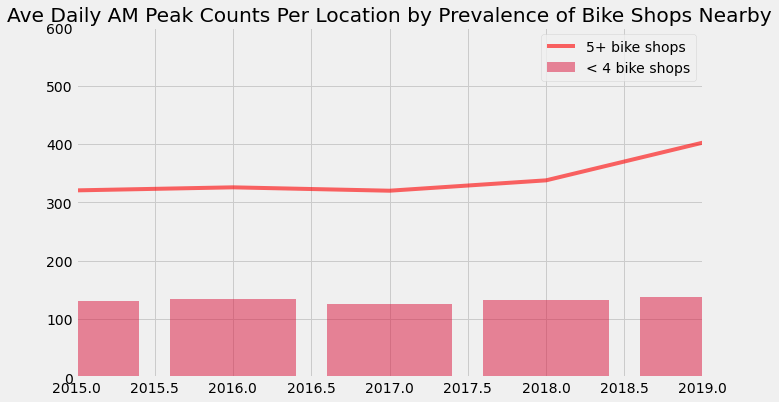

In [219]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(by_year['year'], by_year['few_am_peak_ttl']/5, color = 'crimson', label='< 4 bike shops', alpha=0.5);
ax.plot(by_year['year'], by_year['many_am_peak_ttl']/4, color = 'red', label='5+ bike shops', alpha=0.6);
ax.set_xlim(2015, 2019)
ax.set_ylim(0,600)

ax.set_title("Ave Daily AM Peak Counts Per Location by Prevalence of Bike Shops Nearby")
ax.legend();

## STATS QUESTIONS 

> **Is there a statistical difference between rider counts at locations with more nearby bikeshops than fewer? For the locations with fewer bike shops, does one location have a statistically higher percentage of bike counts than the others?**

In [220]:
weather_by_time_of_trip = df[['am_peak_ttl', 'other_ttl', 'year', 'month', 'dow', 'PRCP', 'TAVG', 'TMIN', "TMAX"]]

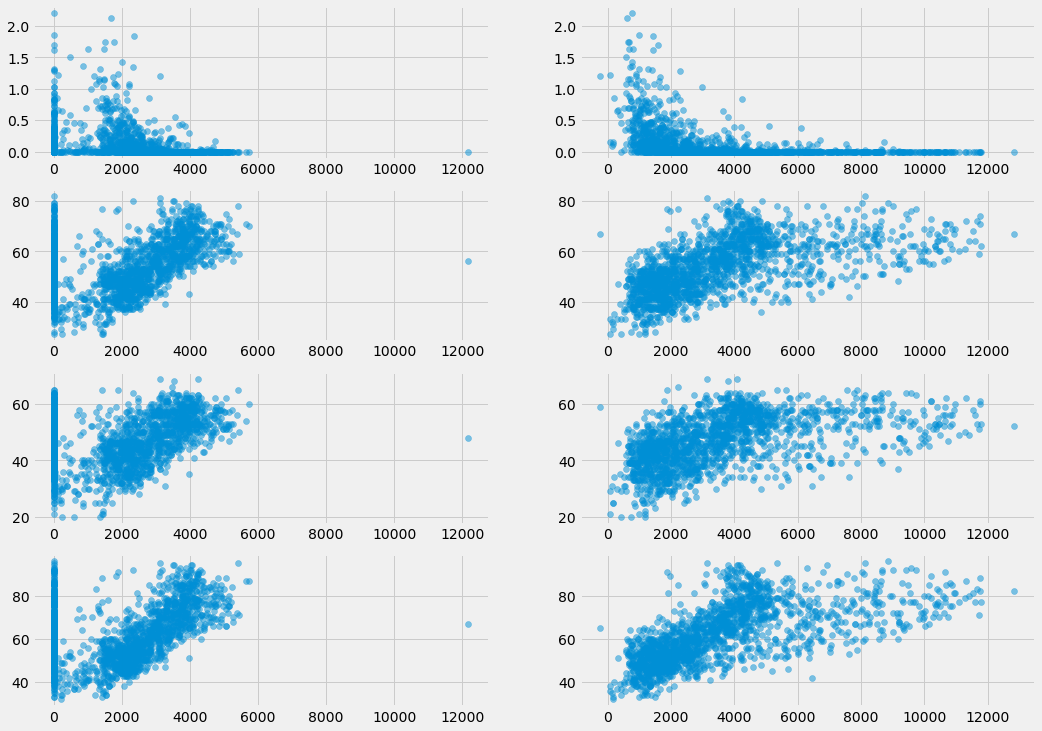

In [221]:
fig, axs = plt.subplots(4, 2, figsize = (16, 12))

for i in range(4):
    for j in range(2):
        axs[i][j].scatter(weather_by_time_of_trip.iloc[:,j], weather_by_time_of_trip.iloc[:, i+5], alpha=0.5)
        
# ax.plot(by_year['year'], by_year['many_am_peak_ttl']/3, color = 'red', label='More bike shops', alpha=0.6);
# ax.set_xlim(2015, 2019)
# ax.set_ylim(0,300)


## STATS QUESTION 

> **Is one temp variable more statistically collinear with ride counts than others? Max temp appears to have less of a scatter.**